## load images

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2
import random
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_crop(image_path):
  image=ImageOps.grayscale(Image.open(image_path))
  image=np.array(image).astype(np.float64)
  newsize=np.min(image.shape)
  image=image[(image.shape[0]/2-newsize/2).astype(int):(image.shape[0]/2-newsize/2).astype(int)+newsize,
              (image.shape[1]/2-newsize/2).astype(int):(image.shape[1]/2-newsize/2).astype(int)+newsize]
  image=cv2.resize(image, (256,256), interpolation = cv2.INTER_LINEAR )
  return (image-np.min(image))/(np.max(image)-np.min(image))
def load_im(group,label,perc):
  all_images = glob.glob(os.path.join('drive','My Drive','chest_xray',group,label, '*.jpeg'))
  print('importing ',str(perc),' images from ',str(len(all_images)),' images...')
  all_images = random.choices(all_images, k=perc)  
  x_data = []
  x_data += [load_crop(image_path) for image_path in all_images]
  return x_data

importing  1  images from  8  images...


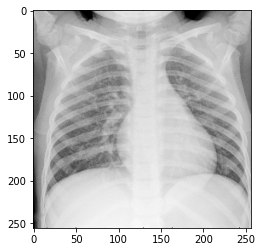

In [ ]:
x_val_n = load_im('val','NORMAL',1)
plt.imshow(x_val_n[0]); plt.gray()

In [ ]:
sample_tvt=[500,8,100]
x_train_n = load_im('train','NORMAL',sample_tvt[0])
x_train_p = load_im('train','PNEUMONIA',sample_tvt[0])
#x_val_n = load_im('val','NORMAL',sample_tvt[1])
#x_val_p = load_im('val','PNEUMONIA',sample_tvt[1])
x_test_n = load_im('test','NORMAL',sample_tvt[2])
x_test_p = load_im('test','PNEUMONIA',sample_tvt[2])

importing  500  images from  1341  images...
importing  500  images from  3875  images...
importing  100  images from  234  images...
importing  100  images from  390  images...


assume these are real world images. They need to be compressed to 256*256 unit8 images. 

In [ ]:
x_train=x_train_n+x_train_p
y_train=[False for i in range(sample_tvt[0])] + [True for i in range(sample_tvt[0])]

x_test=x_test_n+x_test_p
y_test=[False for i in range(sample_tvt[2])] + [True for i in range(sample_tvt[2])]

del x_train_n, x_train_p, x_test_n, x_test_p


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(5)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(5)

## define compression layers
For our optmized compression, we will use butterworth low-pass filter: https://en.wikipedia.org/wiki/Butterworth_filter

tf.Tensor([64 64], shape=(2,), dtype=int32)
4096


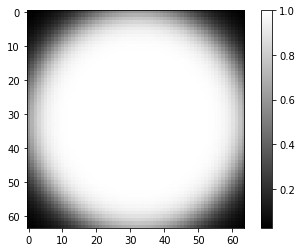

In [ ]:
# inital filter
Y, X = np.ogrid[:64, :64]
r = np.sqrt((X-64/2.0)**2 + (Y-64/2.0)**2)
filterv = tf.Variable(tf.math.reciprocal(1+tf.math.pow(0.03*r,12)).numpy(),trainable=True,dtype=tf.float64)
#filterv =tf.image.central_crop(filterv[...,tf.newaxis] , 0.25)
plt.imshow(np.squeeze(filterv.numpy())); plt.colorbar()
print(tf.shape(filterv))
print(np.sum(filterv.numpy()>1e-2))

In [ ]:
def NormalCompression(x):
  x = tf.image.resize(x,[64,64])
  #x = tf.nn.avg_pool(x, ksize=4, strides=4, padding="SAME")
  #x = tf.image.resize(x,[92,92])
  #x = x[:,::4,::4,:]
  #x = tf.nn.avg_pool(x, ksize=4, strides=4, padding="SAME")
  xmin = tf.reduce_min(tf.reduce_min(x,axis=2,keepdims=True),axis=1,keepdims=True)
  xmax = tf.reduce_max(tf.reduce_max(x,axis=2,keepdims=True),axis=1,keepdims=True)
  x = (x-xmin)/(xmax-xmin)
  #x = tf.cast(tf.cast(x*255,tf.uint8),tf.float64)
  return x

def OptCompression(x):
  x = tf.transpose(x,perm=[0, 3, 1, 2])
  x = tf.cast(x,tf.complex64)
  xf = tf.signal.fftshift(tf.signal.fft2d(x),axes=(2,3))
  #xft = tf.reshape(xf,[tf.shape(xf)[0],1,256*256])
  #xft = tf.math.top_k(tf.cast(tf.abs(xft),tf.float64),k=4096)
  #xft = tf.reduce_min(xft[0],axis=-1)
  
  #tr=tf.math.scalar_mul(omega,tf.Variable(r,dtype=tf.float64,trainable=False))
  #filter = tf.math.reciprocal(1+tf.math.pow(tr,power))
  #filter = tf.math.multiply(filter,tf.cast(filter>scaleb,tf.float64))
  

  xf = tf.transpose(xf,perm=[0, 2, 3, 1])
  xf = tf.image.central_crop(xf, 0.25)
  
  xf = tf.transpose(xf,perm=[0, 3, 1, 2])
  xf = tf.math.multiply(xf,tf.cast(filterv,tf.complex64))
  x = tf.signal.ifft2d(tf.signal.fftshift(xf,axes=(2,3)))
  x = tf.transpose(x,perm=[0, 2, 3, 1])
  x = tf.cast(tf.abs(x),tf.float64)  
  #x = tf.exp(tf.math.scalar_mul(scalek, x) + scaleb)  
  #print(tf.reduce_min(x).numpy())
  #print(tf.reduce_max(x).numpy())
  #x = tf.nn.relu(x-scalek) +scalek
  #x = -tf.nn.relu(-x+scaleb) +scaleb

  xmin = tf.reduce_min(tf.reduce_min(x,axis=2,keepdims=True),axis=1,keepdims=True)
  xmax = tf.reduce_max(tf.reduce_max(x,axis=2,keepdims=True),axis=1,keepdims=True)
  x = (x-xmin)/(xmax-xmin)  
  #x = tf.cast(tf.cast(x*255,tf.uint8),tf.float64)
  return x

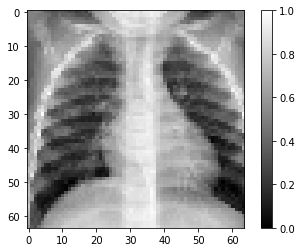

In [ ]:
t=tf.cast(x_test[0],tf.float64)
t=tf.expand_dims(tf.expand_dims(t,-1),0)
tt=NormalCompression(t)

plt.imshow(tt[0,:,:,0].numpy());plt.colorbar()

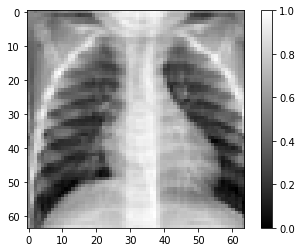

In [ ]:
#filteropt=tf.Variable(np.random.normal(loc=0.0, scale=1.0, size=(4,4,1,1)))
omega=tf.Variable(0.04,trainable=True,dtype=tf.float64)
power=tf.Variable(12.0,trainable=True,dtype=tf.float64)
#scalek=tf.Variable(0.2,trainable=True,dtype=tf.float64)
scaleb=tf.Variable(0.01,trainable=True,dtype=tf.float64)

t=tf.cast(x_test[0],tf.float64)
#t=tf.expand_dims(t,-1)
t=tf.expand_dims(tf.expand_dims(t,-1),0)
tt=OptCompression(t)

plt.imshow(tt[0,:,:,0].numpy());plt.colorbar()

## build model
Use resnet18 from this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7345724/#B55-diagnostics-10-00417

and this code: https://github.com/raghakot/keras-resnet/blob/master/resnet.py


In [ ]:
import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K

def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    #if K.image_dim_ordering() == 'tf':
    ROW_AXIS = 1
    COL_AXIS = 2
    CHANNEL_AXIS = 3
    #else:
        #CHANNEL_AXIS = 1
        #ROW_AXIS = 2
        #COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, filters, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        #if K.image_dim_ordering() == 'tf':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        #conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        #pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
        #block = pool1

        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        block = conv1
        #filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="sigmoid")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, filters):
        return ResnetBuilder.build(input_shape, num_outputs, filters, basic_block, [1, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [ ]:
model = ResnetBuilder.build_resnet_18((1, 64, 64), 1, 8)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 32, 32, 64)   3200        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 64)   256         conv2d_54[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 64)   0           batch_normalization_39[0][0]     
____________________________________________________________________________________________

## training

In [ ]:
del model
model = ResnetBuilder.build_resnet_18((1, 64, 64), 1, 8)

In [ ]:
def forward_model_normal(x_batch):
  p_layer_out = NormalCompression(x_batch)
  return model(p_layer_out)

def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = forward_model_normal(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, trablevar)
  optimizer.apply_gradients(zip(gradients, trablevar))

  train_loss(loss)
  train_accuracy(labels, predictions)

def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = forward_model_normal(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

  # train loop
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

trablevar=[]
for v in model.trainable_variables:
  trablevar.append(v)

EPOCHS = 20

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    labels = tf.cast(labels[..., tf.newaxis],tf.float64)
    images = images[..., tf.newaxis]
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_labels = tf.cast(test_labels[..., tf.newaxis],tf.float64)
    test_images = test_images[..., tf.newaxis]
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.6964796185493469, Accuracy: 59.10000228881836, Test Loss: 0.6527546644210815, Test Accuracy: 72.0
Epoch 2, Loss: 0.6265807151794434, Accuracy: 73.29999542236328, Test Loss: 0.6205021142959595, Test Accuracy: 75.0
Epoch 3, Loss: 0.5901261568069458, Accuracy: 79.19999694824219, Test Loss: 0.5911232829093933, Test Accuracy: 77.5
Epoch 4, Loss: 0.5549201965332031, Accuracy: 82.4000015258789, Test Loss: 0.5698946714401245, Test Accuracy: 74.0
Epoch 5, Loss: 0.5228356719017029, Accuracy: 84.69999694824219, Test Loss: 0.539717435836792, Test Accuracy: 78.5
Epoch 6, Loss: 0.4888833165168762, Accuracy: 86.0, Test Loss: 0.5227243304252625, Test Accuracy: 76.0
Epoch 7, Loss: 0.4525217115879059, Accuracy: 84.69999694824219, Test Loss: 0.4807746410369873, Test Accuracy: 80.5
Epoch 8, Loss: 0.4162798821926117, Accuracy: 87.4000015258789, Test Loss: 0.46107569336891174, Test Accuracy: 78.5
Epoch 9, Loss: 0.3803187906742096, Accuracy: 89.30000305175781, Test Loss: 0.44843727350234985,

In [ ]:
del model_opt

In [ ]:
model_opt= ResnetBuilder.build_resnet_18((1, 64, 64), 1, 8)

def forward_model_opt(x_batch):
  p_layer_out = OptCompression(x_batch)
  return model_opt(p_layer_out)

def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = forward_model_opt(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, trablevar)
  optimizer.apply_gradients(zip(gradients, trablevar))

  train_loss(loss)
  train_accuracy(labels, predictions)

def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = forward_model_opt(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

  # train loop
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

trablevar=[]
#trablevar.append(omega)
#trablevar.append(power)
trablevar.append(filterv)
#trablevar.append(scalek)
#trablevar.append(scaleb)
for v in model_opt.trainable_variables:
  trablevar.append(v)

EPOCHS = 20

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    labels = tf.cast(labels[..., tf.newaxis],tf.float64)
    images = images[..., tf.newaxis]
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_labels = tf.cast(test_labels[..., tf.newaxis],tf.float64)
    test_images = test_images[..., tf.newaxis]
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.8770433068275452, Accuracy: 54.20000076293945, Test Loss: 0.6447197198867798, Test Accuracy: 72.5
Epoch 2, Loss: 0.6404578685760498, Accuracy: 67.4000015258789, Test Loss: 0.6183032989501953, Test Accuracy: 73.0
Epoch 3, Loss: 0.6172581911087036, Accuracy: 72.39999389648438, Test Loss: 0.6071940064430237, Test Accuracy: 68.5
Epoch 4, Loss: 0.5961871147155762, Accuracy: 77.9000015258789, Test Loss: 0.5859060883522034, Test Accuracy: 78.5
Epoch 5, Loss: 0.5774728655815125, Accuracy: 77.5, Test Loss: 0.5679921507835388, Test Accuracy: 78.0
Epoch 6, Loss: 0.5525190234184265, Accuracy: 80.0999984741211, Test Loss: 0.5470983982086182, Test Accuracy: 81.0
Epoch 7, Loss: 0.5273190140724182, Accuracy: 81.19999694824219, Test Loss: 0.5346279740333557, Test Accuracy: 76.5
Epoch 8, Loss: 0.4975874423980713, Accuracy: 82.30000305175781, Test Loss: 0.5044079422950745, Test Accuracy: 78.0
Epoch 9, Loss: 0.4713660180568695, Accuracy: 82.5999984741211, Test Loss: 0.47953444719314575, T

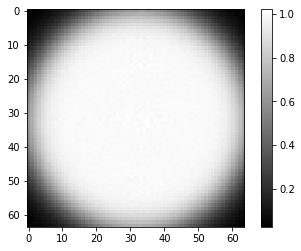

In [ ]:
plt.imshow(filterv.numpy());plt.colorbar()

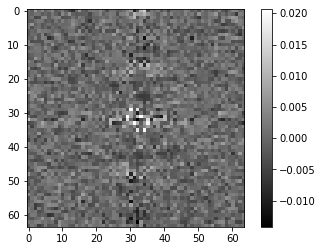

In [ ]:
plt.imshow(filterv.numpy()-tf.math.reciprocal(1+tf.math.pow(0.03*r,12)).numpy());plt.colorbar()

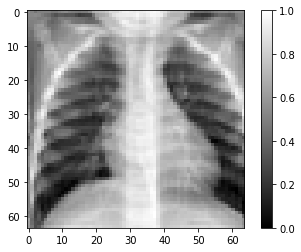

In [ ]:
t=tf.cast(x_test[0],tf.float64)
t=tf.expand_dims(tf.expand_dims(t,-1),0)
tt=OptCompression(t)

plt.imshow(tt[0,:,:,0].numpy());plt.colorbar()
#print(omega.numpy())
#print(power.numpy())

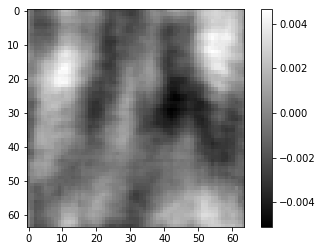

In [ ]:
tempf=filterv.numpy()

filterv=tf.Variable(tf.math.reciprocal(1+tf.math.pow(0.03*r,12)).numpy(),trainable=True,dtype=tf.float64)
t=tf.cast(x_test[0],tf.float64)
t=tf.expand_dims(tf.expand_dims(t,-1),0)
ttt=OptCompression(t)

plt.imshow((tt[0,:,:,0]-ttt[0,:,:,0]).numpy());plt.colorbar()

0.9192
0.9161


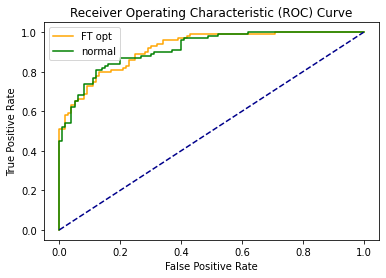

In [ ]:
from sklearn import metrics

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_pred = forward_model_opt(np.asarray(x_test)[..., tf.newaxis])
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred[:,0])
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred[:,0])
print(auc)
y_predn = forward_model_normal(np.asarray(x_test)[..., tf.newaxis])
fprn, tprn, thresholds = metrics.roc_curve(np.asarray(y_test), y_predn[:,0])
auc = metrics.roc_auc_score(np.asarray(y_test), y_predn[:,0])
print(auc)
plt.plot(fpr, tpr, color='orange', label='FT opt')
plt.plot(fprn, tprn, color='green', label='normal')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()